Представим ситуацию: мы хотим, чтобы сервер с нашей моделью одновременно обрабатывал несколько процессов. Если мы попробуем запустить такой сервер, то либо его производительность будет крайне низкой, либо процессы просто не запустятся. Почему?

Дело в механизме под названием GIL — Global Interpreter Lock. Он заключается в том, что в любом процессе Python одновременно может работать только один тред, один конкретный поток. 

То есть процесс Python не может утилизировать многоядерные системы. Для нашей же задачи написания веб-сервера это означает, что сервер на Python одновременно может обрабатывать только один запрос. И это очень серьёзное ограничение даже для самых простых сервисов. 

КАК ЖЕ РЕШИТЬ ПРОБЛЕМУ?
Никто в здравом уме вообще бы не стал использовать Python для веб-серверов, если бы у проблемы не было решения. 

Хитрость заключается в том, что раз один процесс может выполнять только один тред на одном ядре, мы просто запустим несколько процессов, чтобы они работали параллельно. 

Существует несколько разных инструментов, решающих эту задачу, и все они имеют разную степень совместимости с веб-фреймворками Python. Но принцип работы у них один: 

Вы запускаете особую команду и передаёте в ней в качестве параметра указание на скрипт, в котором вы написали свое приложение. 

↓

Эта команда запустит несколько рабочих процессов (копий главного скрипта), а сама будет заниматься прослушиванием входящих запросов и передавать их на обработку в один из запущенных процессов. 

По сути этот процесс работает как менеджер.

Для Flask используются веб-серверы gunicorn, связка nginx + uwsgi и ещё несколько менее популярных. 

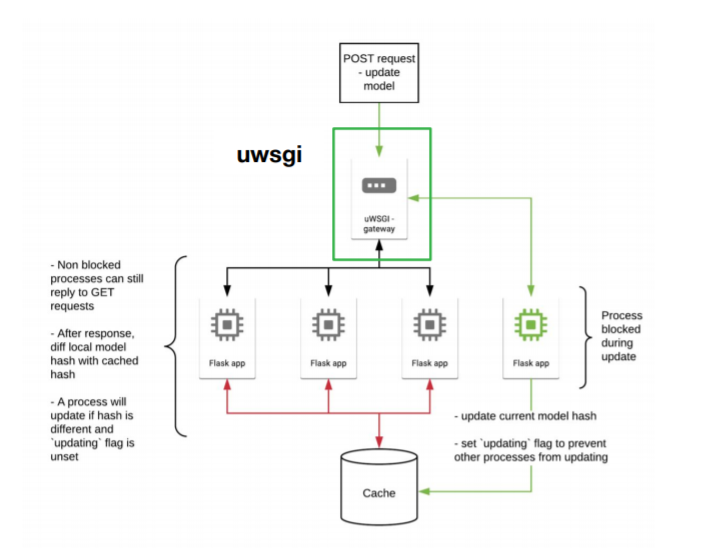

Сегодня мы разберем связку nginx + uwsgi, но так как всё работает по схожему принципу, вам не составит труда самостоятельно разобраться с любым другим способом.

Важно! Мы советуем вам при настройке сервера всегда выполнять изложенные шаги (если только вы не на 100 % уверены, что многопоточность вам не понадобится).

WSGI (Web-Server Gateway Interface) — это, как и следует из названия, интерфейс, который направляет запросы от веб-приложений (программы Python) к веб-серверам и обратно.

WSGI состоит из двух основных сущностей:

- Веб-сервер (Nginx, Apache и т. д.);
- Веб-приложение, написанное на языке Python и wsgi (не путать с uWSGI!) — это бинарный протокол WSGI, оптимизированная версия, которая позволяет достичь ещё большей скорости взаимодействия между сервером и приложением. С ним-то мы и будем работать.

Чтобы запустить ваш сервис в настоящем, боевом режиме, установим uwsgi:

In [ ]:
pip install uwsgi

→ Если с установкой возникли проблемы, загляните в инструкцию: https://uwsgi-docs.readthedocs.io/en/latest/WSGIquickstart.html

Запустим с новоприобретенной командой сервис для нашего коллеги.

In [ ]:
uwsgi --http :5000 --module app:app

Разберём аргументы. 

1. Первый аргумент http :5000 указывает, что uwsgi должен обрабатывать HTTP-запросы на 5000 порту. При необходимости можно указать хост перед двоеточием — localhost или 127.0.0.1 для локального запуска или 0.0.0.0, чтобы сервис был доступен по всем сетевым интерфейсам.
2. Второй аргумент app:app указывает, какое приложение uwsgi будет запускать: модуль app.py (до двоеточия) и объект app внутри этого модуля (после двоеточия).

Давайте проверим количество процессов в системе:

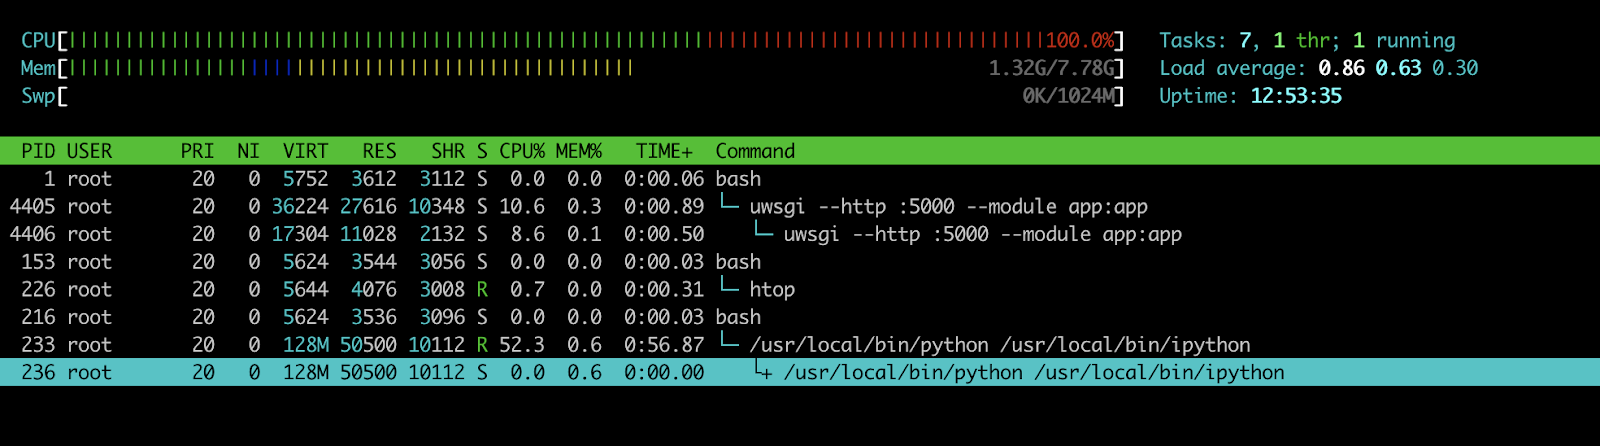

Мы видим один основной процесс, что пока ничем не отличается от обычного запуска скрипта. Давайте добавим больше процессов, чтобы увеличить пропускную способность сервера.

In [ ]:
uwsgi --http :5000 --module app:app --processes 4 --master

Мы увеличили число рабочих процессов до четырёх и добавили мастер-процесс, который будет следить за ними. Сделайте несколько запросов и посмотрите на количество Python-процессов в системе.

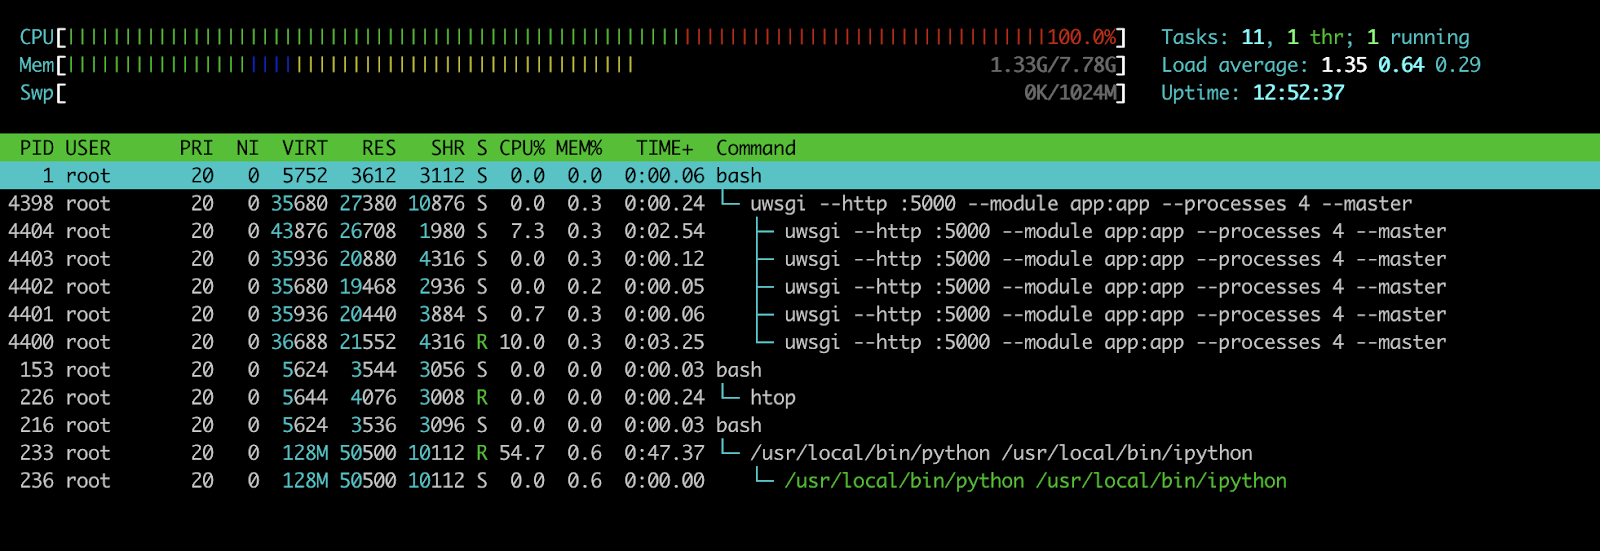

Итак, мы увеличили пропускную способность нашего сервиса. 

Обратите внимание! Это не значит, что запросы будут обрабатываться быстрее — в этом смысле код не изменился и исполняется он такое же количество времени. Зато мы получили возможность параллельно обрабатывать до четырёх запросов.
Но и это еще не всё. На скриншоте видно, что процессов не четыре, а пять. Откуда взялся ещё один? 

Этот последний процесс является HTTP-роутером, который слушает HTTP-трафик и отправляет его на воркеры (рабочие процессы). Однако uswgi — это не самая оптимальная реализация HTTP-роутера. Она существует скорее для отладки, поэтому сами авторы uwsgi советуют использовать полноценный веб-сервер. 

→ И тут на сцену выходит nginx!

nginx — это веб-сервер, который оптимизирует нагрузку за счёт асинхронной архитектуры, управляемой событиями. nginx позволяет обрабатывать одновременно до нескольких тысяч запросов, что и делает его самым популярным веб-сервисом в мире.

УСТАНОВКА NGINX

Установите nginx по инструкции (https://nginx.org/ru/docs/install.html) для вашей системы. Существует и версия для Windows (https://nginx.org/ru/docs/windows.html). Для macOS используйте homebrew (https://medium.com/@ThomasTan/installing-nginx-in-mac-os-x-maverick-with-homebrew-d8867b7e8a5a).

Теперь давайте свяжем uwsgi и nginx. Для этого мы запустим uwsgi без роутера, и он будет слушать трафик прямиком из сокета. 

Теперь давайте свяжем uwsgi и nginx. Для этого мы запустим uwsgi без роутера, и он будет слушать трафик прямиком из сокета. 

Термин: сокет

Сокет — это программный интерфейс для общения между двумя процессами, в нашем случае между nginx и uwsgi. Можно представить его себе как специальный файл в памяти, в который один процесс пишет, а другой оттуда читает.

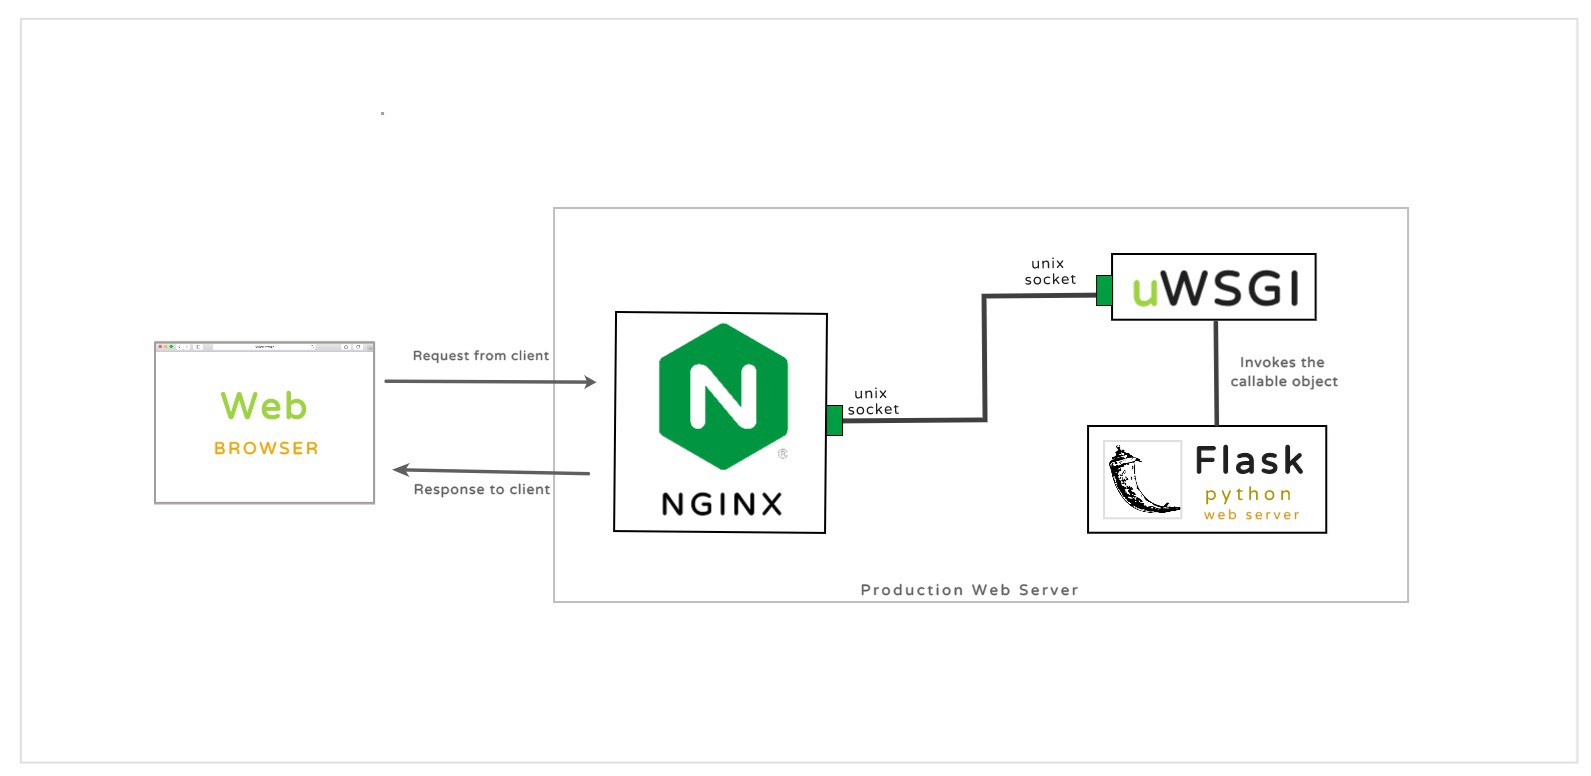

К сожалению, если вы всё еще на Windows, то сокетов у вас нет, и придётся использовать один из портов по этой инструкции (https://serverfault.com/questions/965578/how-to-deploy-a-wsgi-python-app-behind-nginx-on-windows)

Возвращаемся к нашему процессу.

Возвращаемся к нашему процессу.

In [ ]:
uwsgi --socket /tmp/uwsgi.sock --module app:app --master --processes 4

У nginx есть плагин для uwsgi, поэтому нам нужно всего лишь добавить в его конфигурацию запись о том, куда транслировать запросы к серверу и в каком формате.

Выглядит это вот так:

In [ ]:
server {
    listen 5000;
    location / {
        try_files $uri @yourapplication;
    }
    location @yourapplication {
        include uwsgi_params;
        uwsgi_pass unix:///tmp/uwsgi.sock;
    }
}

Положите эту запись в файл /etc/nginx/myapp.conf и перезапустите nginx.

ЧТО ПРОИСХОДИТ? 

При поступлении запроса на порт 5000 nginx транслирует его в обозначенный сокет по протоколу uwsgi. Процесс uwsgi, подключенный к этому сокету, обработает его на одном из запущенных процессов с нашим кодом, и ответ улетит тем же путем в обратной последовательности.

Таким образом, наш сервис теперь стал производительнее, ведь он может обрабатывать несколько запросов параллельно.